<a href="https://colab.research.google.com/github/AkHiLdEvGoD/Transformer-NMT/blob/main/Transformer_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("Aarif1430/english-to-hindi")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-71c2cec7402cd4(…):   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127705 [00:00<?, ? examples/s]

In [86]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents, Sequence
from tokenizers.pre_tokenizers import Whitespace
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence

In [5]:
train_data = dataset['train']
print(train_data[0])

{'english_sentence': "However, Paes, who was partnering Australia's Paul Hanley, could only go as far as the quarterfinals where they lost to Bhupathi and Knowles", 'hindi_sentence': 'आस्ट्रेलिया के पाल हेनली के साथ जोड़ी बनाने वाले पेस मियामी में क्वार्टरफाइनल तक ही पहुंच सके क्योंकि इस दौर में उन्हें भूपति और नोल्स ने हराया था।'}


In [6]:
df = pd.DataFrame(train_data)
df.head()

,english_sentence,hindi_sentence
0,"However, Paes, who was partnering Australia's ...",आस्ट्रेलिया के पाल हेनली के साथ जोड़ी बनाने वाल...
1,"Whosoever desires the reward of the world, wit...",और जो शख्स (अपने आमाल का) बदला दुनिया ही में च...
2,The value of insects in the biosphere is enorm...,"जैव-मंडल में कीड़ों का मूल्य बहुत है, क्योंकि ..."
3,Mithali To Anchor Indian Team Against Australi...,आस्ट्रेलिया के खिलाफ वनडे टीम की कमान मिताली को
4,After the assent of the Honble President on 8t...,"8 सितम्‍बर, 2016 को माननीय राष्‍ट्रपति की स्‍व..."


In [11]:
df = df.rename(columns={'english_sentence':'en','hindi_sentence':'hi'})
df = df.dropna(subset=['en','hi'])

In [14]:
df = df.drop_duplicates(subset=['en', 'hi'])

In [17]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # multiple spaces → single space
    text = text.strip()
    return text

df['en'] = df['en'].apply(clean_text)
df['hi'] = df['hi'].apply(clean_text)

/tmp/ipython-input-1235411876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['en'] = df['en'].apply(clean_text)
/tmp/ipython-input-1235411876.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hi'] = df['hi'].apply(clean_text)


In [43]:
iqr = df['en'].str.len().quantile(0.75) - df['en'].str.len().quantile(0.25)
outliers_en = df['en'].str.len().quantile(0.75) + (1.5*iqr)

iqr = df['hi'].str.len().quantile(0.75) - df['hi'].str.len().quantile(0.25)
outliers_hi = df['hi'].str.len().quantile(0.75) + (1.5*iqr)

int(outliers_hi)

235

In [44]:
df = df[(df['en'].str.len() < int(outliers_en))]
df = df[(df['hi'].str.len() < int(outliers_hi))]

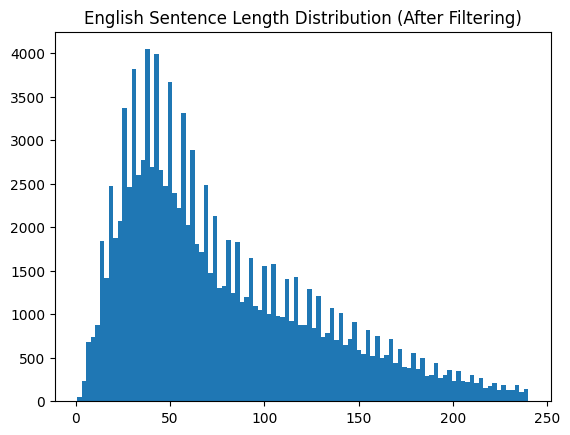

In [46]:
import matplotlib.pyplot as plt

plt.hist(df['en'].str.len(), bins=100)
plt.title("English Sentence Length Distribution (After Filtering)")
plt.show()

In [49]:
train_df,test_df = train_test_split(df,test_size=0.15,random_state=42,shuffle=True)
print(len(train_df))
print(len(test_df))

100340
17708


## Training Tokenizer on the combined corpus

In [51]:
train_corpus = train_df['en'].tolist() + train_df['hi'].tolist()

In [52]:
tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()
trainer = trainers.BpeTrainer(
    vocab_size=20000,  # you can adjust between 16k–32k
    min_frequency=2,
    special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"]
)
tokenizer.train_from_iterator(train_corpus, trainer=trainer)
tokenizer.save("bpe_tokenizer.json")
print("✅ Tokenizer training complete and saved!")

✅ Tokenizer training complete and saved!


In [66]:
tokenizer = Tokenizer.from_file('bpe_tokenizer.json')
sample_en = "How are you?"
sample_hi = "आप कैसे हैं?"

print("English:", tokenizer.encode(sample_en).ids)
print("Hindi:", tokenizer.encode(sample_hi).tokens)

English: [865, 257, 291, 35]
Hindi: ['आप', 'कस', 'ह', '?']


In [88]:
sos_id = tokenizer.token_to_id('<sos>')
eos_id = tokenizer.token_to_id('<eos>')
def encode_texts(text,tokenizer):
  return text.apply(lambda x: [sos_id]+tokenizer.encode(x).ids+[eos_id])

In [91]:
train_df['input_ids'] = encode_texts(train_df['en'],tokenizer)
train_df['target_ids'] = encode_texts(train_df['hi'],tokenizer)

test_df['input_ids'] = encode_texts(test_df['en'],tokenizer)
test_df['target_ids'] = encode_texts(test_df['hi'],tokenizer)

In [94]:
pad_id = tokenizer.token_to_id('<pad>')
def pad_sequences(sequences,pad_token=pad_id):
  return pad_sequence([torch.tensor(seq) for seq in sequences],batch_first=True,padding_value=pad_token)

train_input_padded = pad_sequences(train_df['input_ids'])
train_target_padded = pad_sequences(train_df['target_ids'])

test_input_padded = pad_sequences(test_df['input_ids'])
test_target_padded = pad_sequences(test_df['target_ids'])

In [97]:
class TranslationDataset(Dataset):
  def __init__(self,input,target):
    self.input = input
    self.target = target

  def __len__(self):
    return len(self.input)

  def __getitem__(self,idx):
    return self.input[idx],self.target[idx]

In [98]:
train_dataset = TranslationDataset(train_input_padded,train_target_padded)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)

test_dataset = TranslationDataset(test_input_padded,test_target_padded)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)